# Pre-processing External Datasets

In [1]:
import pandas as pd
import re
import numpy as np
from ast import literal_eval
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Read in datasets
income_df = pd.read_csv("datasource-AU_Govt_ABS-UoM_AURIN_DB_3_abs_personal_income_total_income_sa2_2011_2018.csv")
population_df = pd.read_csv("datasource-AU_Govt_ABS-UoM_AURIN_DB_3_abs_regional_population_sa2_2001_2021.csv")

# Drop irrelevant attributes for income dataset
suburb_info = income_df[["sa2_code", "sa2_name"]]
income_df = income_df.loc[:, "mean_aud_2011_12":]
income_df = income_df.join(suburb_info)

# Rename attributes for income dataset
income_df.columns = ["mean_income_2011_12", "mean_income_2012_13", "mean_income_2013_14", "mean_income_2014_15", 
                     "mean_income_2015_16", "mean_income_2016_17", "mean_income_2017_18", "geometries", "suburb_code", 
                     "suburb"]

# Drop irrelevant attributes for population dataset
estimated_population = population_df.loc[:, "erp_2001":"erp_2021"]
population_df = population_df[["state_name_2016", "sa2_maincode_2016", "sa2_name_2016", "erp_change_per_cent_2020_21", 
                               "area_km2", "pop_density_2021_people_per_km2", "births_2016_17", "deaths_2016_17", 
                               "births_2017_18", "deaths_2017_18", "births_2018_19", "deaths_2018_19", "births_2019_20", 
                               "deaths_2019_20", "births_2020_21", "deaths_2020_21", "geom"]]
population_df = population_df.join(estimated_population)

# Rename attributes for population dataset
population_df.rename(columns={"state_name_2016":"state", "sa2_maincode_2016": "suburb_code", "sa2_name_2016": 
                                              "suburb", "erp_change_per_cent_2020_21": "change_in_population_percentage", 
                                              "area_km2": "suburb_area_km2", "pop_density_2021_people_per_km2": 
                                              "population_density_per_km2", "erp_2001": "population_2001", 
                                              "erp_2002": "population_2002", "erp_2003": "population_2003", 
                                              "erp_2004": "population_2004", "erp_2005": "population_2005", 
                                              "erp_2006": "population_2006", "erp_2007": "population_2007", 
                                              "erp_2008": "population_2008", "erp_2009": "population_2009", 
                                              "erp_2010": "population_2010", "erp_2011": "population_2011", 
                                              "erp_2012": "population_2012", "erp_2013": "population_2013", 
                                              "erp_2014": "population_2014", "erp_2015": "population_2015", 
                                              "erp_2016": "population_2016", "erp_2017": "population_2017", 
                                              "erp_2018": "population_2018", "erp_2019": "population_2019", 
                                              "erp_2020": "population_2020", "erp_2021": "population_2021"}, inplace=True)

# Filter instances in Victoria state for population dataset
population_df = population_df[population_df["state"] == "Victoria"]
suburb_code = population_df[["suburb_code"]]

# Filter instances in Victoria state for income dataset
income_df = pd.merge(income_df, suburb_code, on="suburb_code")

# Drop rows containing NaN values for income dataset
income_df = income_df.dropna().reset_index(drop=True)

# Drop rows without suburb code or suburb name for population dataset
population_df = population_df.dropna().reset_index(drop=True)

# Save dataframes as csv files
income_df.to_csv("income.csv", index=False)
population_df.to_csv("population.csv", index=False)

# Feature Engineering Primary Dataset

In [3]:
# Read in primary dataset
rental_df = pd.read_csv("All_Houses_Scraped.csv")

# Obtain all suburb names in Victoria
state_suburbs_df = pd.read_csv("georef-australia-state-suburb.csv")
state_suburbs_df = state_suburbs_df[state_suburbs_df["Official Name State"] == "Victoria"]
suburbs = [suburb.lower() for suburb in state_suburbs_df["Official Name Suburb"]]
for i in range(len(suburbs)):
    suburbs[i] = re.sub(r'\(.*\)', '', suburbs[i])
    suburbs[i] = suburbs[i].strip()

extra_suburbs = ["preston west", "prahran east", "sanctuary lakes", "mallacoota"]
for i in range(len(extra_suburbs)):
    suburbs.append(extra_suburbs[i])
    
# Convert address to list
rental_df["name"] = rental_df["name"].str.split(' ')

# Create new column for postcodes
rental_df["postcode"] = [row[-1] for row in rental_df["name"]]

# Create new columns for potential suburb names
rental_df["name_one"] = [row[-3].lower() for row in rental_df["name"]]
rental_df["name_two"] = [row[-4:-2] for row in rental_df["name"]]
rental_df["name_three"] = [row[-5:-2] for row in rental_df["name"]]

# Convert potential suburb names from list to string
rental_df["name_two"] = rental_df["name_two"].str.join(' ')
rental_df["name_two"] = [row.lower() for row in rental_df["name_two"]]
rental_df["name_three"] = rental_df["name_three"].str.join(' ')
rental_df["name_three"] = [row.lower() for row in rental_df["name_three"]]

i = 0
for suburb_one, suburb_two, suburb_three in zip(rental_df.iloc[:, -3], rental_df.iloc[:, -2], rental_df.iloc[:, -1]):
    if suburb_three in suburbs:
        rental_df.loc[i, ["suburb"]] = suburb_three
    elif suburb_two in suburbs:
        rental_df.loc[i, ["suburb"]] = suburb_two
    elif suburb_one in suburbs:
        rental_df.loc[i, ["suburb"]] = suburb_one
    i += 1

rental_df = rental_df.drop(columns=["name_one", "name_two", "name_three"])

# Drop rows containing at least one null value in primary dataset
rental_df = rental_df.dropna(axis=0, how ="any")

In [4]:
# Drop rows without room information
rental_df["rooms"] = rental_df["rooms"].replace("[]", np.nan)
rental_df = rental_df.dropna(subset = ["rooms"] , how="any").reset_index(drop=True)

# Set up cases for extracting room information
info_one = '|'.join(["bed"])
info_two = '|'.join(["bath"])
info_three = '|'.join(["park"])
numbers = '\d+[.,]?\d*'                              
case_one = fr'({numbers})(?:[\s\d\-\+\/]*)(?:{info_one})'
case_two = fr'({numbers})(?:[\s\d\-\+\/]*)(?:{info_two})'
case_three = fr'({numbers})(?:[\s\d\-\+\/]*)(?:{info_three})'
pattern_one = re.compile(case_one) 
pattern_two = re.compile(case_two) 
pattern_three = re.compile(case_three) 

# Create columns for the number of beedrooms, bathrooms and parking spaces
for i in range(len(rental_df)):
    rental_df["rooms"].loc[i] = literal_eval(rental_df["rooms"].loc[i])
    for j in range(len(rental_df["rooms"].loc[i])):
        rental_df["rooms"].loc[i][j] = rental_df["rooms"].loc[i][j].lower()     
        if pattern_one.findall(rental_df["rooms"].loc[i][j]) != []:
            rental_df.loc[i, "bedrooms"] = pattern_one.findall(rental_df["rooms"].loc[i][j])
        elif pattern_two.findall(rental_df["rooms"].loc[i][j]) != []:
            rental_df.loc[i, "bathrooms"] = pattern_two.findall(rental_df["rooms"].loc[i][j])
        else:
            rental_df.loc[i, "parking_spaces"] = pattern_three.findall(rental_df["rooms"].loc[i][j])

# Preliminary Analysis - Primary Dataset

In [2]:
# Create density plot 
def kde_plot(df, attribute, title, x_label, file_name):
    sns.kdeplot(data=df, x=attribute)
    plt.title(title)
    plt.xlabel(x_label)
    #plt.savefig(file_name + ".png", transparent=True, facecolor="white", bbox_inches="tight")
    plt.show()
    plt.close()
    
# Create scatter plot for attribute vs rental cost
def scatter_plot(df, attribute, x_label, title):
    plt.figure(figsize=(15,7))
    sns.scatterplot(data=df, x=attribute, y="cost_text")
    plt.xlabel(x_label)
    plt.ylabel("Rental Cost ($)")
    plt.title(title)
    #plt.savefig(file_name + ".png", transparent=True, facecolor="white", bbox_inches="tight")
    plt.show()
    plt.close()
    
# Colour code each suburb based on distance to Melbourne CBD
def colour_code(suburb):
    if (0 <= suburb["CBD_Distance"] < 10):
        colour = "green"
    elif (10 <= suburb["CBD_Distance"] < 20):
        colour = "lime"
    elif (20 <= suburb["CBD_Distance"] < 30):
        colour = "yellow"
    elif (30 <= suburb["CBD_Distance"] < 40):
        colour = "gold"
    elif (40 <= suburb["CBD_Distance"] < 50):
        colour = "orange"
    elif (50 <= suburb["CBD_Distance"] < 60):
        colour = "tomato"
    elif (60 <= suburb["CBD_Distance"] < 100):
        colour = "red"
    elif (100 <= suburb["CBD_Distance"] < 150):
        colour = "darkred"
    elif (150 <= suburb["CBD_Distance"] < 200):
        colour = "purple"
    elif (200 <= suburb["CBD_Distance"] < 700):
        colour = "black"
    else:
        colour = "black"
        print("WHYYYY")
        print(suburb)
    return colour

In [12]:
rental_df = pd.read_csv("Final_Preprocessed_Scraped_Rental.csv")
print(rental_df.head())

   Unnamed: 0                 coordinates  cost_text  postcode      suburb  \
0           0  [-37.9032708, 145.0770553]      680.0      3166  hughesdale   
1           1   [-37.9077745, 145.092738]      650.0      3166    oakleigh   
2           2  [-37.8922004, 145.0899378]      500.0      3166    oakleigh   
3           3  [-37.8972564, 145.0871089]      570.0      3166    oakleigh   
4           4    [-37.894307, 145.082706]      475.0      3166  hughesdale   

   bedrooms  bathrooms  parking_spaces  house_postcode  nearest_hospital  \
0         3          2             2.0            3166            3.6709   
1         3          2             2.0            3166            4.4447   
2         1          1             1.0            3166            5.7190   
3         3          2             2.0            3166            5.0104   
4         2          1             1.0            3166            5.1099   

   nearest_train_station  distance_to_cbd  nearest_school  
0             

# Density Plots

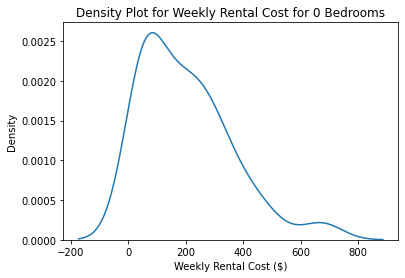

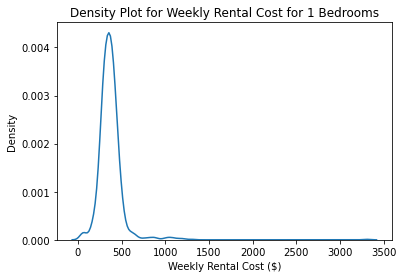

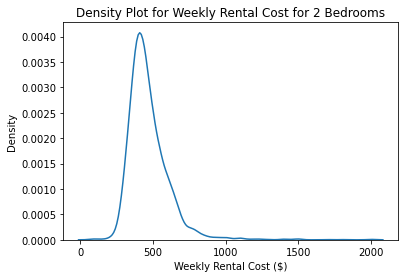

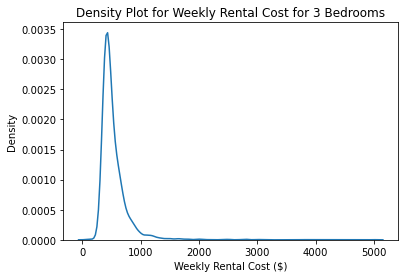

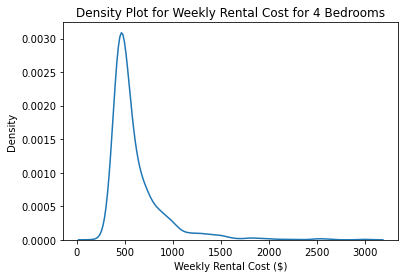

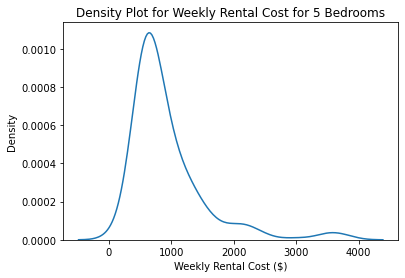

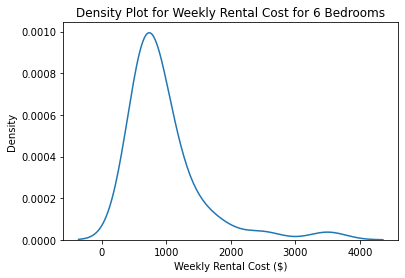

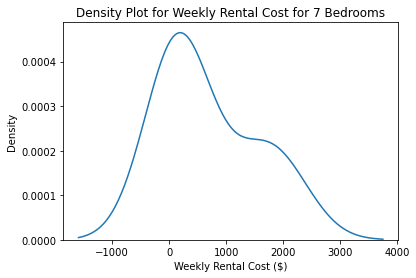

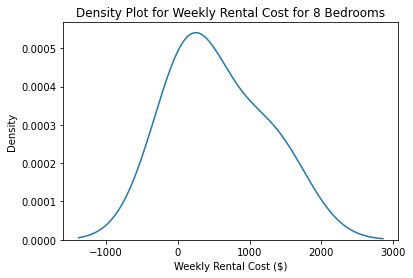

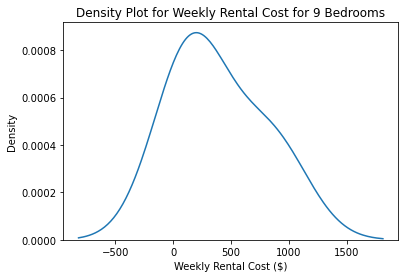

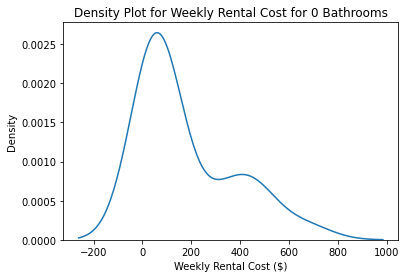

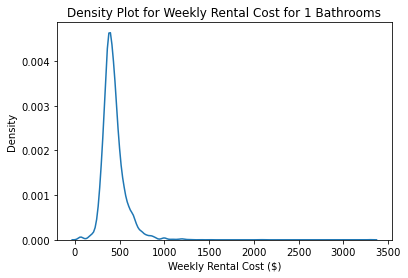

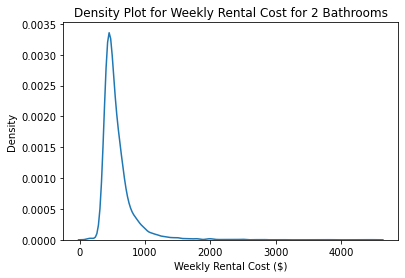

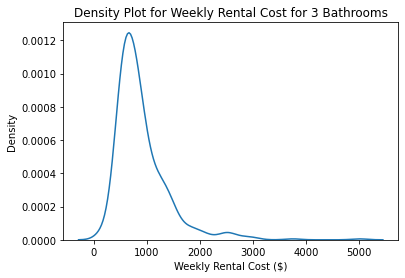

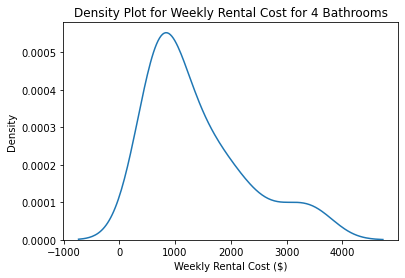

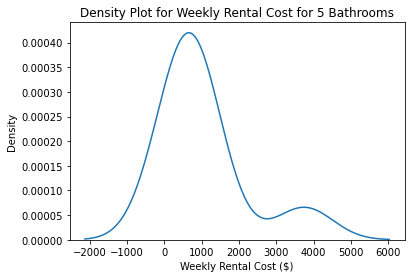

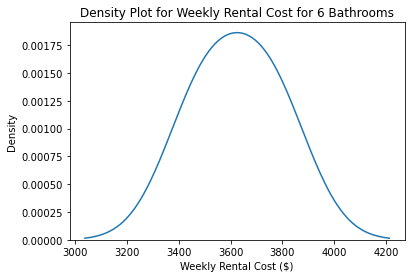

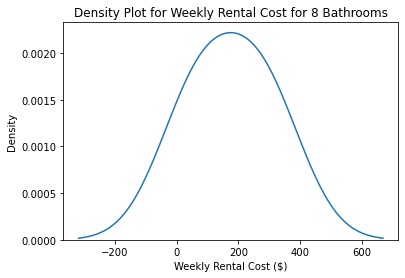

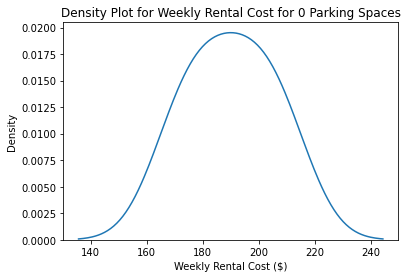

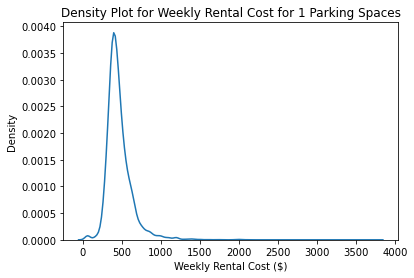

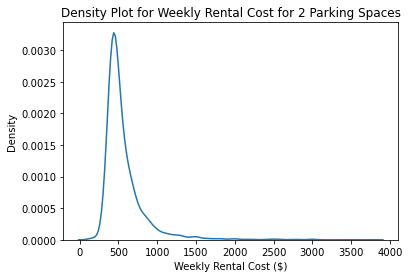

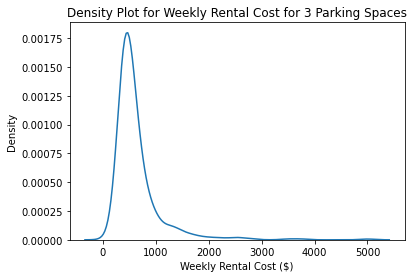

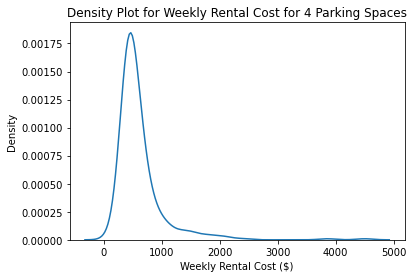

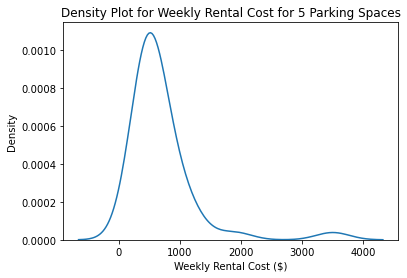

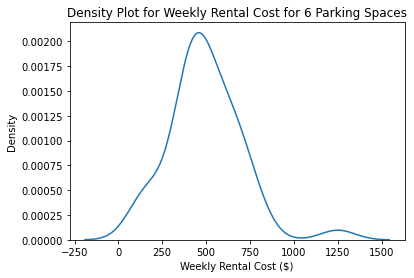

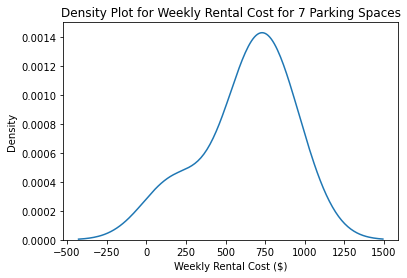

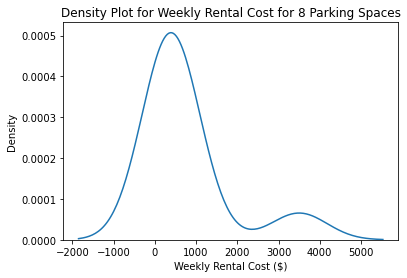

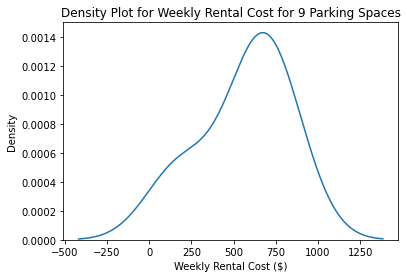

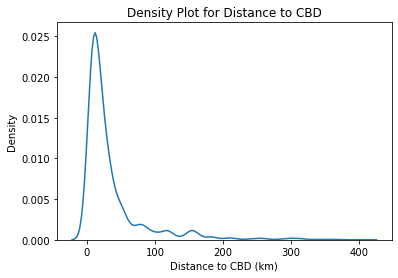

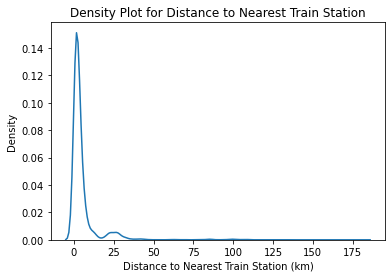

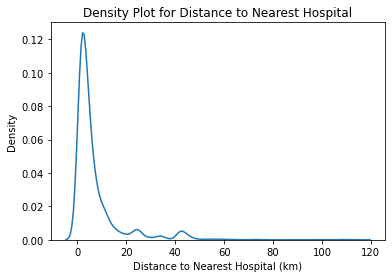

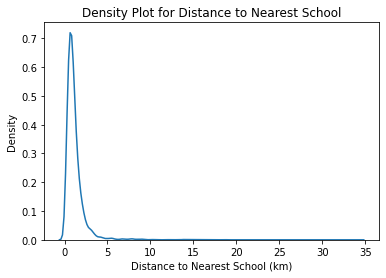

In [7]:
# Obtain recorded number of bedrooms, bathrooms and parking spaces (all unique values)
bedrooms_list = sorted(rental_df["bedrooms"].unique())
bathrooms_list = sorted(rental_df["bathrooms"].unique())
parking_spaces_list = rental_df["parking_spaces"].unique()
parking_spaces_list = sorted([int(i) for i in parking_spaces_list])

# Create density plots for the cost text of each unique number of bedrooms
for i in bedrooms_list:
    bedroom_df = rental_df[rental_df["bedrooms"]==i]
    kde_plot(bedroom_df, "cost_text", "Density Plot for Weekly Rental Cost for {bedroom} Bedrooms".format(bedroom = i), 
             "Weekly Rental Cost ($)", "density_plot_{bedroom}bedrooms".format(bedroom = i))
    
# Create density plots for the cost text of each unique number of bathrooms
for i in bathrooms_list:
    bathroom_df = rental_df[rental_df["bathrooms"]==i]
    kde_plot(bathroom_df, "cost_text", "Density Plot for Weekly Rental Cost for {bathroom} Bathrooms".format(bathroom = i), 
             "Weekly Rental Cost ($)", "density_plot_{bathroom}bathrooms".format(bathroom = i))

# Create density plots for the cost text of each unique number of parking spaces
for i in parking_spaces_list:
    parking_spaces_df = rental_df[rental_df["parking_spaces"]==i]
    kde_plot(parking_spaces_df, "cost_text", "Density Plot for Weekly Rental Cost for {parking_space} Parking Spaces".format(parking_space = i), 
             "Weekly Rental Cost ($)", "density_plot_{parking_space}parking_spaces".format(parking_space = i))

# Create density plot for distance to CBD
kde_plot(rental_df, "distance_to_cbd", "Density Plot for Distance to CBD", "Distance to CBD (km)", "density_plot_distance_to_CBD")

# Create density plot for distance to nearest train station
kde_plot(rental_df, "nearest_train_station", "Density Plot for Distance to Nearest Train Station", "Distance to Nearest Train Station (km)", "density_plot_distance_to_nearest_train_station")

# Create density plot for distance to nearest hospital
kde_plot(rental_df, "nearest_hospital", "Density Plot for Distance to Nearest Hospital", "Distance to Nearest Hospital (km)", "density_plot_distance_to_nearest_hospital")

# Create density plot for distance to nearest school
kde_plot(rental_df, "nearest_school", "Density Plot for Distance to Nearest School", "Distance to Nearest School (km)", "density_plot_distance_to_nearest_school")

# Correlation Heatmaps

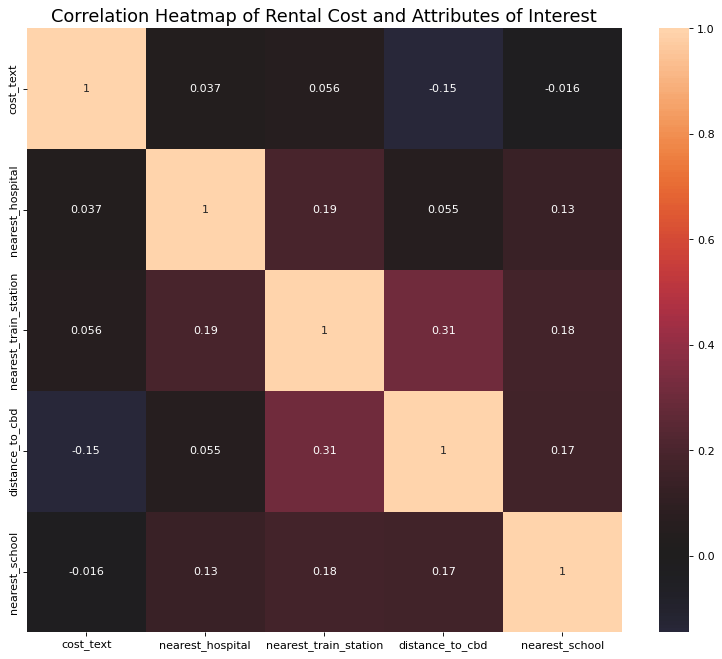

In [23]:
# Drop non-continuous attributes
heatmap_df = rental_df.drop(["Unnamed: 0", "coordinates", "postcode", "suburb", "bedrooms", "bathrooms", "parking_spaces", 
                             "house_postcode"], axis=1)

# Plot correlation heatmap of continuous attributes 
plt.figure(figsize=(12,10), dpi=80)
sns.heatmap(heatmap_df.corr(), xticklabels=heatmap_df.corr().columns, yticklabels=heatmap_df.corr().columns, center=0, annot=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Heatmap of Rental Cost and Attributes of Interest", fontsize=16)
#plt.savefig("correlation_heatmap.png", facecolor="white", bbox_inches="tight")
plt.show()
plt.close()

# Bar Plots

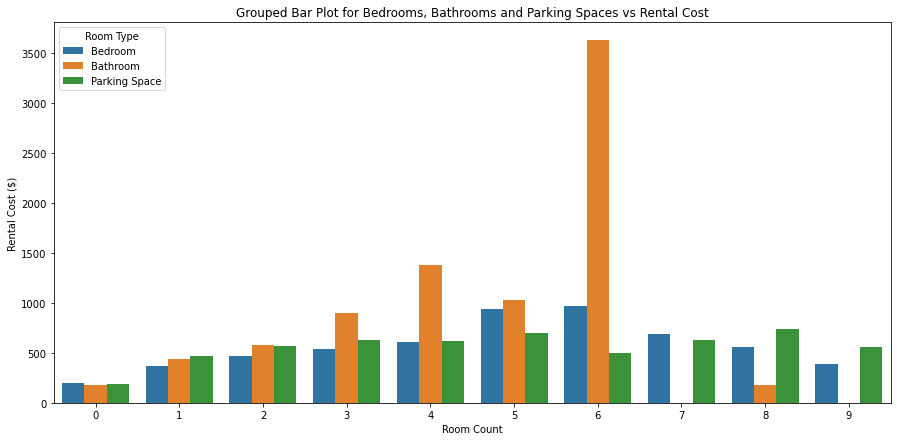

In [8]:
# Create grouped bar plot of number of bedrooms, bathrooms and parking spaces vs rental cost
grouped_bedrooms_df = rental_df[["bedrooms", "cost_text"]].groupby("bedrooms").agg({"cost_text": "mean"}).rename({"cost_text": "Bedroom"}, axis=1)
grouped_bathrooms_df = rental_df[["bathrooms", "cost_text"]].groupby("bathrooms").agg({"cost_text": "mean"}).rename({"cost_text": "Bathroom"}, axis=1)
grouped_parking_spaces_df = rental_df[["parking_spaces", "cost_text"]].groupby("parking_spaces").agg({"cost_text": "mean"}).rename({"cost_text": "Parking Space"}, axis=1)
grouped_rooms_df = pd.concat([grouped_bedrooms_df, grouped_bathrooms_df, grouped_parking_spaces_df], axis=1).melt()
grouped_rooms_df["room_count"] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.figure(figsize=(15,7))
grouped_barplot = sns.barplot(data=grouped_rooms_df, x="room_count", y="value", hue="variable")
grouped_barplot.legend(title="Room Type")
plt.xlabel("Room Count")
plt.ylabel("Rental Cost ($)")
plt.title("Grouped Bar Plot for Bedrooms, Bathrooms and Parking Spaces vs Rental Cost")
plt.show()
plt.close()

# Scatter Plots

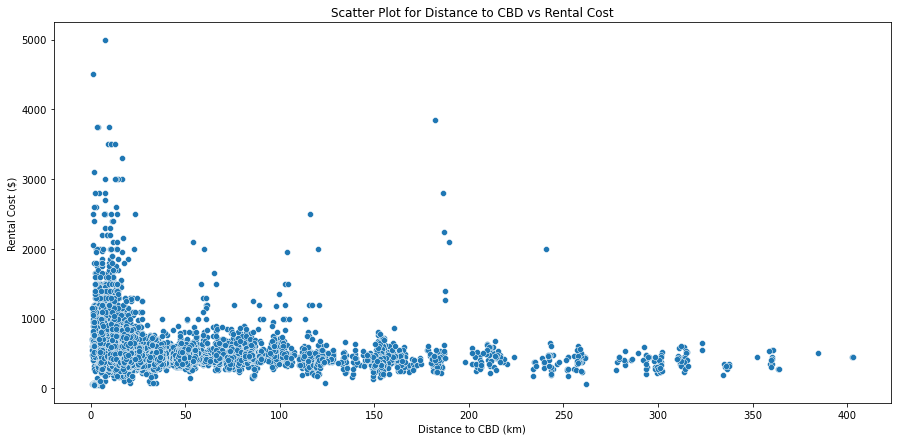

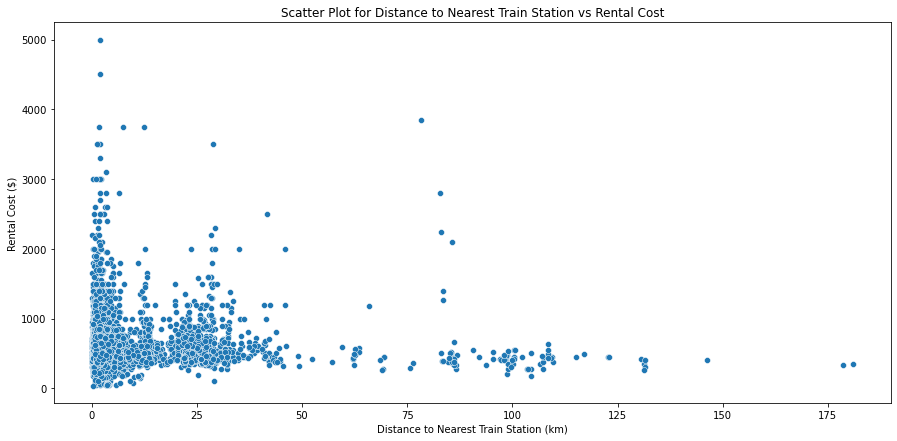

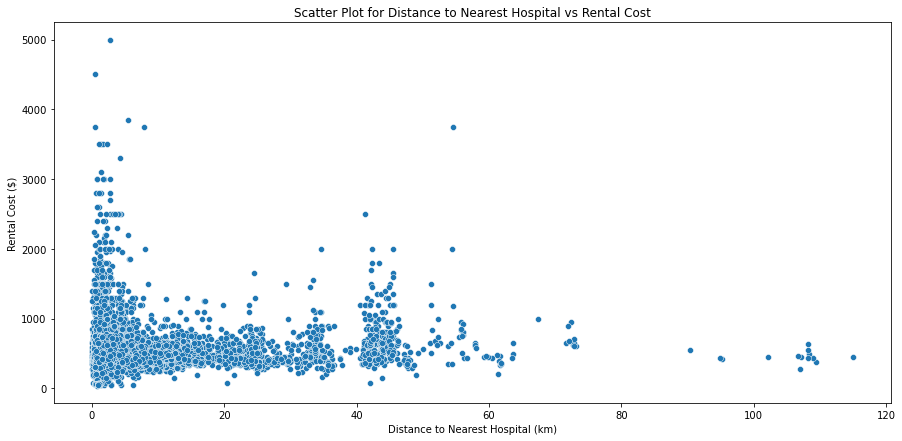

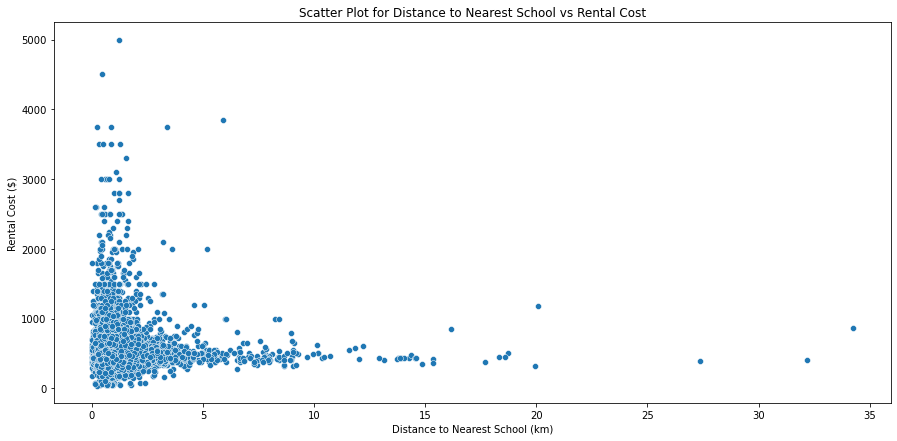

In [10]:
# Create scatter plot of distance to CBD vs rental cost
scatter_plot(rental_df, "distance_to_cbd", "Distance to CBD (km)", "Scatter Plot for Distance to CBD vs Rental Cost")

# Create scatter plot of distance to nearest train station vs rental cost
scatter_plot(rental_df, "nearest_train_station", "Distance to Nearest Train Station (km)", "Scatter Plot for Distance to Nearest Train Station vs Rental Cost")

# Create scatter plot of distance to CBD vs rental cost
scatter_plot(rental_df, "nearest_hospital", "Distance to Nearest Hospital (km)", "Scatter Plot for Distance to Nearest Hospital vs Rental Cost")

# Create scatter plot of distance to CBD vs rental cost
scatter_plot(rental_df, "nearest_school", "Distance to Nearest School (km)", "Scatter Plot for Distance to Nearest School vs Rental Cost")

# ANOVA